# Лабораторная работа №1

Давыдов Егор, 7 Вариант

## Utils.py:

In [1]:
"""Some auxiliary files used for honor track numpy assignment"""


import numpy as np
from random import randrange

def eval_numerical_gradient(f, x, verbose=False, h=0.00001):
    """Evaluates gradient df/dx via finite differences:
    df/dx ~ (f(x+h) - f(x-h)) / 2h
    Adopted from https://github.com/ddtm/dl-course/ (our ysda course).
    """
    fx = f(x) # evaluate function value at original point
    grad = np.zeros_like(x)
    # iterate over all indexes in x
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:

        # evaluate function at x+h
        ix = it.multi_index
        oldval = x[ix]
        x[ix] = oldval + h # increment by h
        fxph = f(x) # evalute f(x + h)
        x[ix] = oldval - h
        fxmh = f(x) # evaluate f(x - h)
        x[ix] = oldval # restore

        # compute the partial derivative with centered formula
        grad[ix] = (fxph - fxmh) / (2 * h) # the slope
        if verbose:
            print (ix, grad[ix])
        it.iternext() # step to next dimension

    return grad



import sys
import os
import time

import numpy as np

def load_mnist(flatten=False):
    """taken from https://github.com/Lasagne/Lasagne/blob/master/examples/mnist.py"""
    # We first define a download function, supporting both Python 2 and 3.
    if sys.version_info[0] == 2:
        from urllib import urlretrieve
    else:
        from urllib.request import urlretrieve

    def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
        print("Downloading %s" % filename)
        urlretrieve(source + filename, filename)

    # We then define functions for loading MNIST images and labels.
    # For convenience, they also download the requested files if needed.
    import gzip

    def load_mnist_images(filename):
        if not os.path.exists(filename):
            download(filename)
        # Read the inputs in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
        # The inputs are vectors now, we reshape them to monochrome 2D images,
        # following the shape convention: (examples, channels, rows, columns)
        data = data.reshape(-1, 1, 28, 28)
        # The inputs come as bytes, we convert them to float32 in range [0,1].
        # (Actually to range [0, 255/256], for compatibility to the version
        # provided at http://deeplearning.net/data/mnist/mnist.pkl.gz.)
        return data / np.float32(256)

    def load_mnist_labels(filename):
        if not os.path.exists(filename):
            download(filename)
        # Read the labels in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=8)
        # The labels are vectors of integers now, that's exactly what we want.
        return data

    # We can now download and read the training and test set images and labels.
    X_train = load_mnist_images('train-images-idx3-ubyte.gz')
    y_train = load_mnist_labels('train-labels-idx1-ubyte.gz')
    X_test = load_mnist_images('t10k-images-idx3-ubyte.gz')
    y_test = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

    # We reserve the last 10000 training examples for validation.
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]
    
    if flatten:
        X_train = X_train.reshape([X_train.shape[0],-1])
        X_val = X_val.reshape([X_val.shape[0],-1])
        X_test = X_test.reshape([X_test.shape[0],-1])

    # We just return all the arrays in order, as expected in main().
    # (It doesn't matter how we do this as long as we can read them again.)
    return X_train, y_train, X_val, y_val, X_test, y_test

import matplotlib.pyplot as plt
def plot_embedding(X, y):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})
    plt.xticks([]), plt.yticks([])

## Базовый класс Layer:

In [2]:
class Layer:
    """
    A building block. Each layer is capable of performing two things:
    
    - Process input to get output:           output = layer.forward(input)
    
    - Propagate gradients through itself:    grad_input = layer.backward(input, grad_output)
    
    Some layers also have learnable parameters which they update during layer.backward.
    """
    def __init__(self):
        """Here you can initialize layer parameters (if any) and auxiliary stuff."""
        # An identity layer does nothing
        pass
    
    def forward(self, input):
        """
        Takes input data of shape [batch, input_units], returns output data [batch, output_units]
        """
        # An identity layer just returns whatever it gets as input.
        return input

    def backward(self, input, grad_output):
        """
        Performs a backpropagation step through the layer, with respect to the given input.
        
        To compute loss gradients w.r.t input, you need to apply chain rule (backprop):
        
        d loss / d x  = (d loss / d layer) * (d layer / d x)
        
        Luckily, you already receive d loss / d layer as input, so you only need to multiply it by d layer / d x.
        
        If your layer has parameters (e.g. dense layer), you also need to update them here using d loss / d layer
        """
        # The gradient of an identity layer is precisely grad_output
        input_dim = input.shape[1]
        
        d_layer_d_input = np.eye(input_dim)
        
        return np.dot(grad_output, d_layer_d_input) # chain rule

## ReLU слой:

In [4]:
class ReLU(Layer):
    def __init__(self):
        """ReLU layer simply applies elementwise rectified linear unit to all inputs"""
        pass
    
    def forward(self, input):
        """Apply elementwise ReLU to [batch, input_units] matrix"""
        return np.maximum(0, input)
    
    def backward(self, input, grad_output):
        """Compute gradient of loss w.r.t. ReLU input"""
        relu_grad_mask = input > 0
        return grad_output * relu_grad_mask


## Тестирование реализации ReLU слоя:

In [5]:
import numpy as np

# Создаем объект ReLU слоя
l = ReLU()

# Генерируем тестовые данные
points = np.linspace(-1, 1, 10 * 32).reshape([10, 32])

# Получаем градиенты с помощью метода backward
grads = l.backward(points, np.ones([10, 32]) / (32 * 10))

# Вычисляем численные градиенты
numeric_grads = eval_numerical_gradient(lambda x: l.forward(x).mean(), x=points)

# Проверяем близость вычисленных градиентов
assert np.allclose(grads, numeric_grads, rtol=1e-3, atol=0), \
    "gradient returned by your layer does not match the numerically computed gradient"

print("Тестирование пройдено успешно!")


Тестирование пройдено успешно!


## Полносвязный слой:

In [7]:
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate=0.1):
        """
        A dense layer is a layer which performs a learned affine transformation:
        f(x) = <W*x> + b
        """
        self.learning_rate = learning_rate
        
        # initialize weights with small random numbers from normal distribution
        self.weights = np.random.randn(input_units, output_units) * 0.01
        self.biases = np.zeros(output_units)
        
    def forward(self, input):
        """
        Perform an affine transformation:
        f(x) = <W*x> + b
        
        input shape: [batch, input_units]
        output shape: [batch, output units]
        """
        return np.dot(input, self.weights) + self.biases
    
    def backward(self, input, grad_output):
        """
        Perform a backpropagation step through the layer.
        
        input: [batch, input_units]
        grad_output: [batch, output_units]
        """
        # Compute gradient of loss w.r.t. input
        grad_input = np.dot(grad_output, self.weights.T)
        
        # Compute gradient w.r.t. weights and biases
        grad_weights = np.dot(input.T, grad_output)
        grad_biases = np.sum(grad_output, axis=0)
        
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape
        
        # Update weights and biases using gradient descent
        self.weights -= self.learning_rate * grad_weights
        self.biases -= self.learning_rate * grad_biases
        
        return grad_input


## Тесты:

In [8]:
l = Dense(128, 150)

assert -0.05 < l.weights.mean() < 0.05 and 1e-3 < l.weights.std() < 1e-1,\
    "The initial weights must have zero mean and small variance. "\
    "If you know what you're doing, remove this assertion."
assert -0.05 < l.biases.mean() < 0.05, "Biases must be zero mean. Ignore if you have a reason to do otherwise."

# To test the outputs, we explicitly set weights with fixed values. DO NOT DO THAT IN ACTUAL NETWORK!
l = Dense(3,4)

x = np.linspace(-1,1,2*3).reshape([2,3])
l.weights = np.linspace(-1,1,3*4).reshape([3,4])
l.biases = np.linspace(-1,1,4)

assert np.allclose(l.forward(x),np.array([[ 0.07272727,  0.41212121,  0.75151515,  1.09090909],
                                          [-0.90909091,  0.08484848,  1.07878788,  2.07272727]]))
print("Well done!")

Well done!


In [10]:
# To test the grads, we use gradients obtained via finite differences
x = np.linspace(-1,1,10*32).reshape([10,32])
l = Dense(32,64,learning_rate=0)

numeric_grads = eval_numerical_gradient(lambda x: l.forward(x).sum(),x)
grads = l.backward(x,np.ones([10,64]))

assert np.allclose(grads,numeric_grads,rtol=1e-3,atol=0), "input gradient does not match numeric grad"
print("Well done!")

Well done!


In [11]:
#test gradients w.r.t. params
def compute_out_given_wb(w,b):
    l = Dense(32,64,learning_rate=1)
    l.weights = np.array(w)
    l.biases = np.array(b)
    x = np.linspace(-1,1,10*32).reshape([10,32])
    return l.forward(x)
    
def compute_grad_by_params(w,b):
    l = Dense(32,64,learning_rate=1)
    l.weights = np.array(w)
    l.biases = np.array(b)
    x = np.linspace(-1,1,10*32).reshape([10,32])
    l.backward(x,np.ones([10,64]) / 10.)
    return w - l.weights, b - l.biases
    
w,b = np.random.randn(32,64), np.linspace(-1,1,64)

numeric_dw = eval_numerical_gradient(lambda w: compute_out_given_wb(w,b).mean(0).sum(),w )
numeric_db = eval_numerical_gradient(lambda b: compute_out_given_wb(w,b).mean(0).sum(),b )
grad_w,grad_b = compute_grad_by_params(w,b)

assert np.allclose(numeric_dw,grad_w,rtol=1e-3,atol=0), "weight gradient does not match numeric weight gradient"
assert np.allclose(numeric_db,grad_b,rtol=1e-3,atol=0), "weight gradient does not match numeric weight gradient"
print("Well done!")

Well done!


## Функция потерь:

In [12]:
def softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy from logits[batch,n_classes] and ids of correct answers"""
    logits_for_answers = logits[np.arange(len(logits)),reference_answers]
    
    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits),axis=-1))
    
    return xentropy

def grad_softmax_crossentropy_with_logits(logits,reference_answers):
    """Compute crossentropy gradient from logits[batch,n_classes] and ids of correct answers"""
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)),reference_answers] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    
    return (- ones_for_answers + softmax) / logits.shape[0]

In [13]:
logits = np.linspace(-1,1,500).reshape([50,10])
answers = np.arange(50)%10

softmax_crossentropy_with_logits(logits,answers)
grads = grad_softmax_crossentropy_with_logits(logits,answers)
numeric_grads = eval_numerical_gradient(lambda l: softmax_crossentropy_with_logits(l,answers).mean(),logits)

assert np.allclose(numeric_grads,grads,rtol=1e-3,atol=0), "The reference implementation has just failed. Someone has just changed the rules of math."

## Итоговая нейросеть:

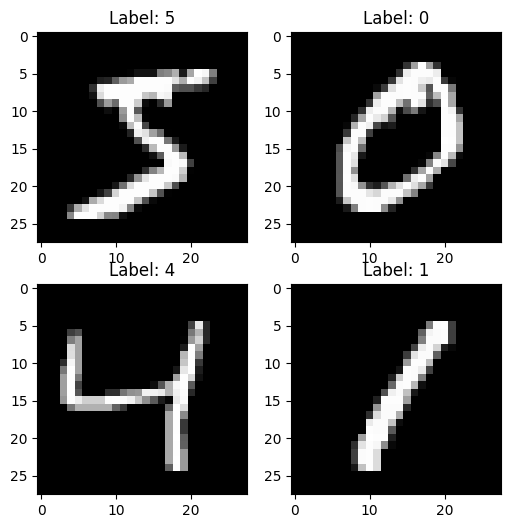

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

X_train, y_train, X_val, y_val, X_test, y_test = load_mnist(flatten=True)

plt.figure(figsize=[6,6])
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title("Label: %i"%y_train[i])
    plt.imshow(X_train[i].reshape([28,28]),cmap='gray');

In [16]:
network = []
hidden_layers_size = 40
network.append(Dense(X_train.shape[1], hidden_layers_size))
network.append(ReLU())
network.append(Dense(hidden_layers_size, hidden_layers_size))
network.append(ReLU())
network.append(Dense(hidden_layers_size, 10))

In [17]:
def forward(network, X):
    """
    Compute activations of all network layers by applying them sequentially.
    Return a list of activations for each layer. 
    Make sure last activation corresponds to network logits.
    """
    activations = []
    input = X
    
    for layer in network:
        input = layer.forward(input)
        activations.append(input)
    
    assert len(activations) == len(network)
    return activations

def predict(network, X):
    """
    Use network to predict the most likely class for each sample.
    """
    logits = forward(network, X)[-1]
    return logits.argmax(axis=-1)


In [18]:
def train(network, X, y):
    """
    Train your network on a given batch of X and y.
    You first need to run forward to get all layer activations.
    Then you can run layer.backward going from last to first layer.
    
    After you called backward for all layers, all Dense layers have already made one gradient step.
    """
    
    # Get the layer activations
    layer_activations = forward(network, X)
    layer_inputs = [X] + layer_activations  # layer_input[i] is an input for network[i]
    logits = layer_activations[-1]
    
    # Compute the loss and the initial gradient
    loss = softmax_crossentropy_with_logits(logits, y)
    loss_grad = grad_softmax_crossentropy_with_logits(logits, y)
        
    # Propagate gradients through network layers using .backward
    # Hint: start from last layer and move to earlier layers
    for layer_idx in range(len(network) - 1, -1, -1):
        loss_grad = network[layer_idx].backward(layer_inputs[layer_idx], loss_grad)
        
    return np.mean(loss)


In [20]:
from tqdm.auto import tqdm
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in tqdm(range(0, len(inputs) - batchsize + 1, batchsize)):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [21]:
from IPython.display import clear_output
train_log = []
val_log = []

Epoch 14
Train accuracy: 0.99094
Val accuracy: 0.9688


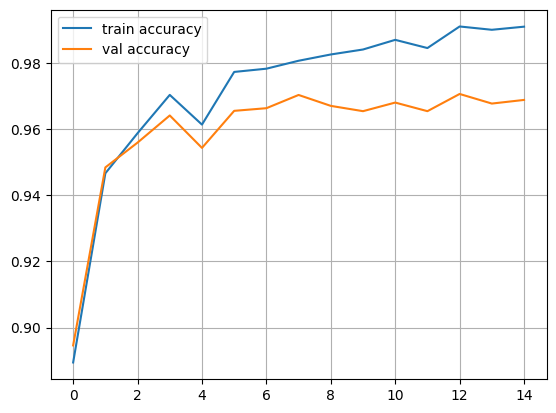

In [22]:
for epoch in range(15):

    for x_batch,y_batch in iterate_minibatches(X_train, y_train, batchsize=32, shuffle=True):
        train(network, x_batch, y_batch)
    
    train_log.append(np.mean(predict(network, X_train) == y_train))
    val_log.append(np.mean(predict(network, X_val) == y_val))
    
    clear_output()
    print("Epoch",epoch)
    print("Train accuracy:",train_log[-1])
    print("Val accuracy:",val_log[-1])
    plt.plot(train_log,label='train accuracy')
    plt.plot(val_log,label='val accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()
    

## Нейросеть для извлечения представлений:

In [23]:
train_activations = forward(network, X_train)
train_hidden_representations = train_activations[2]
test_activations = forward(network, X_test)
test_hidden_representations = test_activations[2]

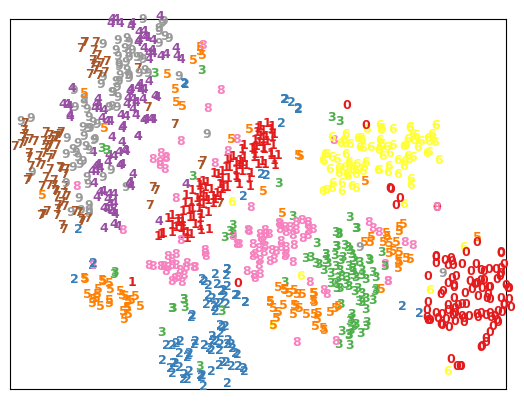

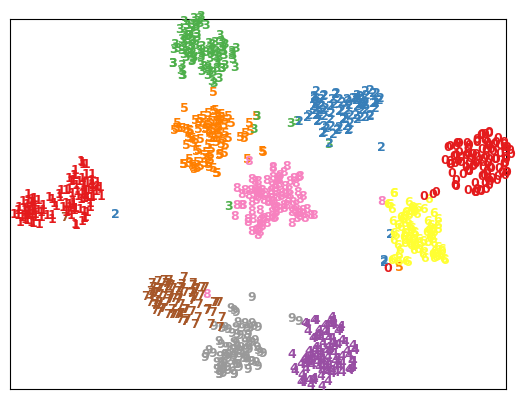

In [25]:
from sklearn.manifold import TSNE

subset_ids = np.random.permutation(X_train.shape[0])[:1000]

# Выполним t-SNE для изначальных 784-мерных представлений
tsne_original = TSNE(n_components=2)
x_original_tsne = tsne_original.fit_transform(X_train[subset_ids])

# Выполним t-SNE для обученных представлений
tsne_learnt = TSNE(n_components=2)
x_learnt_tsne = tsne_learnt.fit_transform(train_hidden_representations[subset_ids])

# Построим визуализации

#t-SNE визуализация для исходных представлений
plot_embedding(x_original_tsne, y_train[subset_ids])

#t-SNE визуализация для обученных представлений
plot_embedding(x_learnt_tsne, y_train[subset_ids])


## Простейшая логистическая регресия, предсказывающая четность изображенной цифры, используя в качестве вектора признаков: исходные 784-мерные представленияобученные представления

### Подготовим новые целевые метки для обучения и тестирования:

In [28]:
new_y_train = y_train % 2
new_y_test = y_test % 2


### Обучаем

In [30]:
from sklearn.linear_model import LogisticRegression

# Создадим и обучим логистическую регрессию для исходных 784-мерных представлений
lr_original = LogisticRegression(solver="liblinear")
lr_original.fit(X_train, new_y_train)

# Создадим и обучим логистическую регрессию для обученных представлений
lr_learnt = LogisticRegression(solver="liblinear")
lr_learnt.fit(train_hidden_representations, new_y_train)


LogisticRegression(solver='liblinear')

### Оценка:

In [31]:
from sklearn.metrics import accuracy_score

# Оценим качество для исходных 784-мерных представлений
accuracy_original = accuracy_score(new_y_test, lr_original.predict(X_test))
print("Accuracy для исходных 784-мерных представлений:", accuracy_original)

# Оценим качество для обученных представлений
accuracy_learnt = accuracy_score(new_y_test, lr_learnt.predict(test_hidden_representations))
print("Accuracy для обученных представлений:", accuracy_learnt)


Accuracy для исходных 784-мерных представлений: 0.9023
Accuracy для обученных представлений: 0.9478


## Контрольные вопросы

1) Биологический и искусственный нейрон. Основные функции активации нейронов.

- Биологический нейрон: Это базовая единица нервной системы животных и людей. Он состоит из тела клетки, дендритов (получающих входные сигналы), аксона (передающего выходные сигналы) и синапсов (соединяющих структур, через которые передаются сигналы). Биологический нейрон генерирует электрические импульсы (или действительно, спайки), которые передаются по нейронной сети.

- Искусственный нейрон (или нейрон в искусственной нейронной сети): Это математическая абстракция, созданная для имитации функций биологического нейрона. Он принимает входные данные, вычисляет их сумму с весами (взвешенные входы), применяет активационную функцию к этой сумме, а затем передает результат на выход. Искусственные нейроны используются в искусственных нейронных сетях для выполнения различных задач машинного обучения и обработки данных.

Основные функции активации нейронов:

 - Сигмоидная функция (логистическая функция): Преобразует взвешенную сумму входов в диапазоне от 0 до 1. Это полезно для моделирования вероятностей и для решения задач бинарной классификации.

- Гиперболический тангенс (tanh): Преобразует взвешенную сумму входов в диапазоне от -1 до 1. Подобно сигмоидной функции, но имеет более высокий градиент, что может ускорить обучение сети.

- Rectified Linear Unit (ReLU): Преобразует взвешенную сумму входов входов в 0, если она отрицательная, и взвешенную сумму, если она положительная. Это помогает решить проблему затухающих градиентов и ускоряет обучение.

2) Преимущества нейронных сетей.

- Способность к обучению сложных нелинейных моделей: Нейронные сети способны обнаруживать и изучать сложные нелинейные взаимосвязи в данных, что делает их мощным инструментом для решения широкого круга задач.
- Адаптивность к данным: Нейронные сети могут автоматически извлекать признаки из данных, что делает их подходящими для обработки неструктурированных данных, таких как изображения, аудио и текст.
- Масштабируемость: Нейронные сети могут быть масштабированы для работы с большими объемами данных и сложными моделями.
- Устойчивость к шуму: Некоторые архитектуры нейронных сетей, такие как сверточные нейронные сети (CNN), обладают устойчивостью к шуму и вариациям в данных.

3) Классификации нейронных сетей, области применения и решаемые задачи. Основные направления развития нейрокомпьютинга.

- По архитектуре:
- - Полносвязные нейронные сети (Fully Connected NN)
- - Сверточные нейронные сети (Convolutional Neural Networks, CNN)
- - Рекуррентные нейронные сети (Recurrent Neural Networks, RNN)
- - Глубокие нейронные сети (Deep Neural Networks, DNN)
- - Рекуррентные сверточные нейронные сети (Recurrent Convolutional Neural Networks, RCNN)
- - Многослойные перцептроны (Multilayer Perceptrons, MLP)

- Области применения и решаемые задачи:
- - Классификация: Распознавание образов, определение категорий, анализ тональности и т. д.
- - Регрессия: Прогнозирование, моделирование зависимостей, аппроксимация функций и т. д.
- - Кластеризация: Группировка данных на основе их сходства.
- - Обработка естественного языка: Перевод, генерация текста, сентимент-анализ и т. д.
- - Компьютерное зрение: Детекция объектов, сегментация изображений, классификация и т. д.
- - Управление: Автономные системы, робототехника и т. д.
- - Направления развития нейрокомпьютинга:

- Исследование новых архитектур нейронных сетей: Развитие новых типов слоев, функций активации, архитектур и методов обучения.
- -Интеграция с другими технологиями: Комбинирование нейронных сетей с методами глубокого обучения, природными вычислениями и другими техниками.
- - Разработка эффективных алгоритмов обучения: Создание алгоритмов обучения, способных эффективно работать с большими объемами данных и сложными моделями.
- - Применение в новых областях: Использование нейронных сетей для решения задач в биологии, медицине, финансах, науке о материалах и других областях.